<a href="https://colab.research.google.com/github/Henriquerocha2000/telecomX2/blob/main/Telecom_X_%E2%80%93_Parte_2_Prevendo_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Preparação dos Dados

In [100]:
import pandas as pd
dados_telecom = pd.read_csv('/content/dados_telecomX_tratados.csv')
dados_telecom.head()

,ID_Cliente,Cancelou,Genero,Idoso,Possui_Parceiro,Possui_Dependentes,Meses_de_Contrato,Telefone_Ativo,Multiplas_Linhas,Tipo_Internet,...,Protecao_Dispositivo,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Tipo_Contrato,Fatura_Digital,Metodo_Pagamento,Cobranca_Mensal,Cobranca_Total,Contas_Diarias
0,0002-ORFBO,0.0,Female,0,1.0,1.0,9,1.0,No,Dsl,...,No,Yes,Yes,No,One year,1.0,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0.0,Male,0,0.0,0.0,9,1.0,Yes,Dsl,...,No,No,No,Yes,Month-to-month,0.0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1.0,Male,0,0.0,0.0,4,1.0,No,Fiber Optic,...,Yes,No,No,No,Month-to-month,1.0,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1.0,Male,1,1.0,0.0,13,1.0,No,Fiber Optic,...,Yes,No,Yes,Yes,Month-to-month,1.0,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1.0,Female,1,1.0,0.0,3,1.0,No,Fiber Optic,...,No,Yes,Yes,No,Month-to-month,1.0,Mailed check,83.9,267.40,2.796667


In [101]:
#apriori a coluna id_clientes é denecessaria
dados_telecom = dados_telecom.drop(columns=["ID_Cliente"])
dados_telecom.isna().sum()

,0
Cancelou,224
Genero,0
Idoso,0
Possui_Parceiro,0
Possui_Dependentes,0
Meses_de_Contrato,0
Telefone_Ativo,0
Multiplas_Linhas,0
Tipo_Internet,0
Seguranca_Online,0


In [102]:
#transformando as variáveis categóricas em formato numérico
col_categor = dados_telecom.select_dtypes(include="object").columns.tolist()

# aplicando One-Hot Encoding
df_encoded = pd.get_dummies(dados_telecom, columns=col_categor, drop_first=True)

print("Colunas após One-Hot Encoding:")
print(df_encoded.columns.tolist())

Colunas após One-Hot Encoding:
['Cancelou', 'Idoso', 'Possui_Parceiro', 'Possui_Dependentes', 'Meses_de_Contrato', 'Telefone_Ativo', 'Fatura_Digital', 'Cobranca_Mensal', 'Cobranca_Total', 'Contas_Diarias', 'Genero_Male', 'Multiplas_Linhas_No phone service', 'Multiplas_Linhas_Yes', 'Tipo_Internet_Fiber Optic', 'Tipo_Internet_No', 'Seguranca_Online_No internet service', 'Seguranca_Online_Yes', 'Backup_Online_No internet service', 'Backup_Online_Yes', 'Protecao_Dispositivo_No internet service', 'Protecao_Dispositivo_Yes', 'Suporte_Tecnico_No internet service', 'Suporte_Tecnico_Yes', 'Streaming_TV_No internet service', 'Streaming_TV_Yes', 'Streaming_Filmes_No internet service', 'Streaming_Filmes_Yes', 'Tipo_Contrato_One year', 'Tipo_Contrato_Two year', 'Metodo_Pagamento_Credit card (automatic)', 'Metodo_Pagamento_Electronic check', 'Metodo_Pagamento_Mailed check']


In [103]:
# contagem de clientes que cancelaram vs. os que não cancelaram
contagem = df_encoded['Cancelou'].value_counts(dropna=False)

# proporção de cada classe
proporcao = contagem / len(df_encoded)

print("Contagem:\n", contagem)
print("\nProporção:\n", proporcao)

Contagem:
 Cancelou
0.0    5174
1.0    1869
NaN     224
Name: count, dtype: int64

Proporção:
 Cancelou
0.0    0.711986
1.0    0.257190
NaN    0.030824
Name: count, dtype: float64


In [104]:
df_encoded = df_encoded.dropna()
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# Já removeu os NaNs anteriormente com dropna()
# Agora separa X e y
X = df_encoded.drop("Cancelou", axis=1)
y = df_encoded["Cancelou"]

# Aplica SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Verifica nova distribuição
print("Distribuição após SMOTE:", Counter(y_res))



Distribuição após SMOTE: Counter({0.0: 5163, 1.0: 5163})


In [105]:
# normalizacao para modelos sensíveis a escala
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

#2.Correlação e Seleção de Variáveis

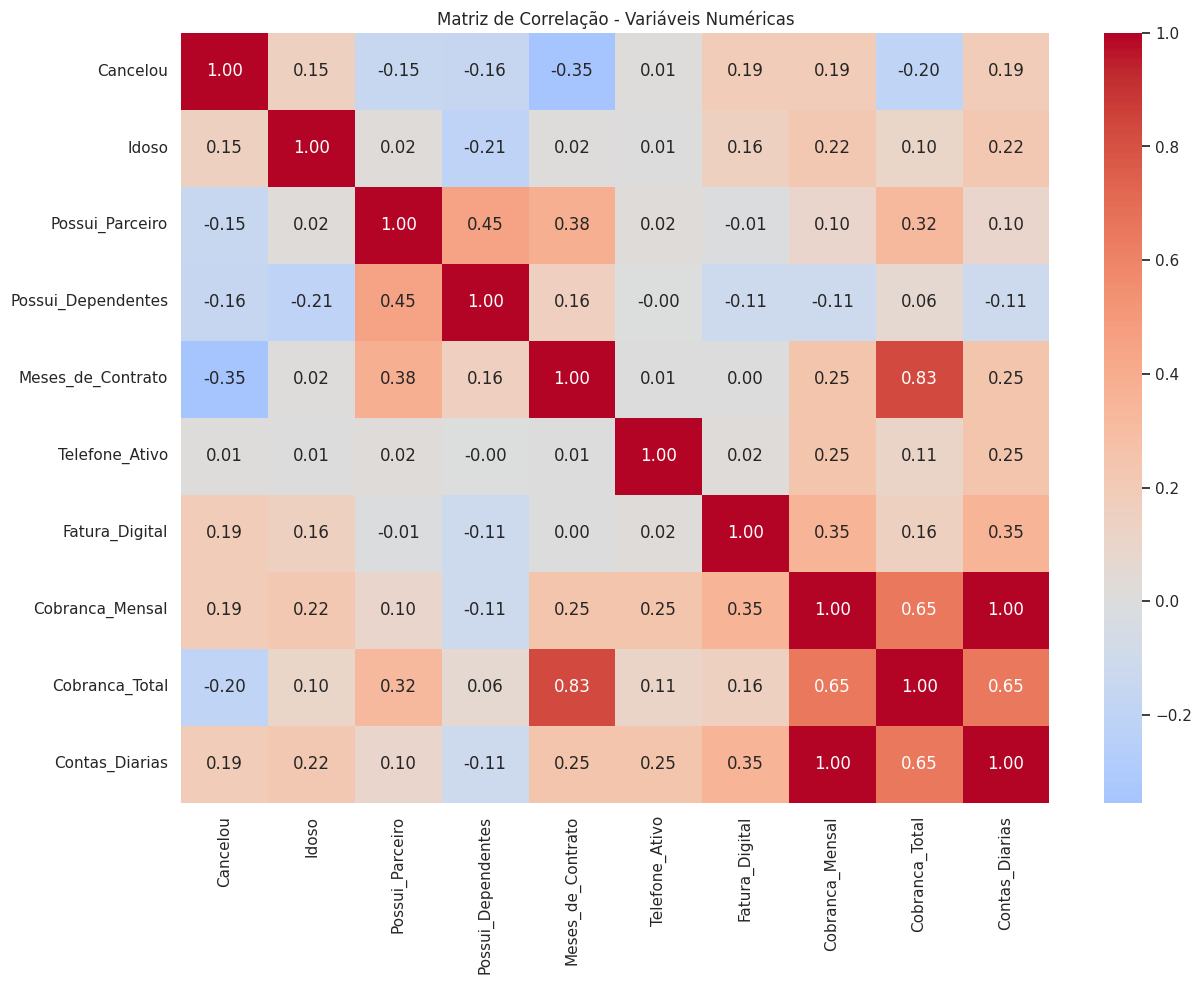

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# selecionando apenas colunas numericas
numericas = df_encoded.select_dtypes(include=["int64", "float64"])

# calcular a matriz de correlacao
correlacao = numericas.corr()

# plotar o heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()


/tmp/ipython-input-3263813898.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_encoded, x='Cancelou', y='Meses_de_Contrato', palette="Set2")
/tmp/ipython-input-3263813898.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_encoded, x='Cancelou', y='Cobranca_Total', palette="Set2")


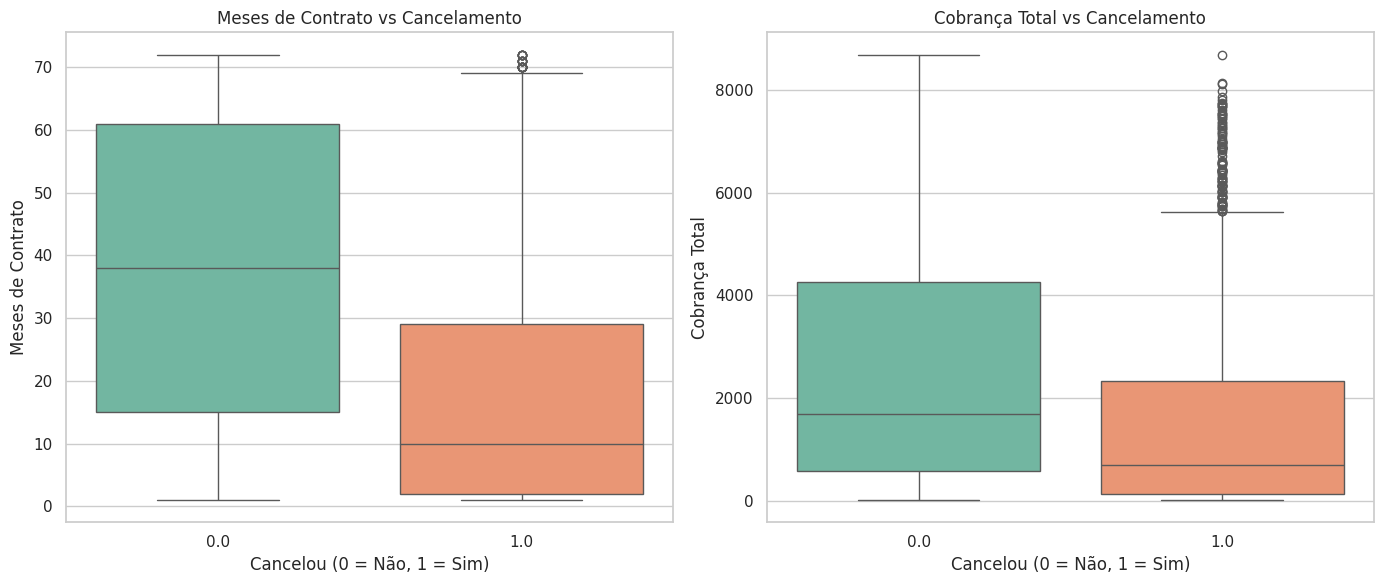

In [107]:
#foi observado que Meses_de_Contrato, Cobranca_Total, Cobranca_Mensal, Fatura_Digital e Contas_Diarias possuem maior potencial preditivo.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

# Boxplot 1: Meses de Contrato vs Cancelamento
plt.subplot(1, 2, 1)
sns.boxplot(data=df_encoded, x='Cancelou', y='Meses_de_Contrato', palette="Set2")
plt.title('Meses de Contrato vs Cancelamento')
plt.xlabel('Cancelou (0 = Não, 1 = Sim)')
plt.ylabel('Meses de Contrato')

# Boxplot 2: Cobrança Total vs Cancelamento
plt.subplot(1, 2, 2)
sns.boxplot(data=df_encoded, x='Cancelou', y='Cobranca_Total', palette="Set2")
plt.title('Cobrança Total vs Cancelamento')
plt.xlabel('Cancelou (0 = Não, 1 = Sim)')
plt.ylabel('Cobrança Total')

plt.tight_layout()
plt.show()


Analisando a relação Meses de Contrato com Cancelamento, percebe-se que clientes com mesno mese de contrto cancelam mais, já com a relação Cobrança Total com Cancelamento mostra que clienes que gastam mais com o serviço tendem a cancelar menos, o que pode justificar com a permancia por mais tempo.  

#3.Modelagem Preditiva

In [108]:
from sklearn.model_selection import train_test_split

# Separando variáveis independentes (X) e dependente (y)
X = df_encoded.drop('Cancelou', axis=1)
y = df_encoded['Cancelou']

# Divisão 70% treino e 30% teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Verificando os tamanhos
print("Tamanho do conjunto de treino:", X_treino.shape)
print("Tamanho do conjunto de teste:", X_teste.shape)


Tamanho do conjunto de treino: (4922, 31)
Tamanho do conjunto de teste: (2110, 31)


In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Divisão dos dados balanceados (X_res, y_res) vindos do SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# -----------------------------
# Modelo 1: Regressão Logística (com normalização)
# -----------------------------
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("Regressão Logística=>")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


# -----------------------------
# Modelo 2: Random Forest (sem normalização)
# -----------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest=>")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Regressão Logística=>
[[1268  281]
 [ 270 1279]]
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      1549
         1.0       0.82      0.83      0.82      1549

    accuracy                           0.82      3098
   macro avg       0.82      0.82      0.82      3098
weighted avg       0.82      0.82      0.82      3098

Random Forest=>
[[1321  228]
 [ 224 1325]]
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85      1549
         1.0       0.85      0.86      0.85      1549

    accuracy                           0.85      3098
   macro avg       0.85      0.85      0.85      3098
weighted avg       0.85      0.85      0.85      3098



/tmp/ipython-input-455716625.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Variável', data=df_import, palette='viridis')


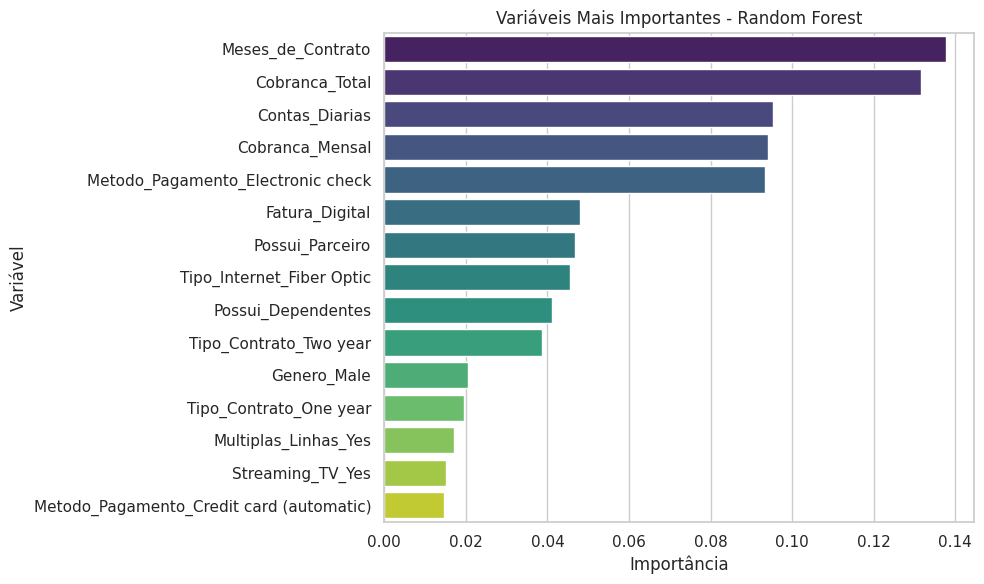

/tmp/ipython-input-455716625.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Variável', data=df_coef, palette='coolwarm')


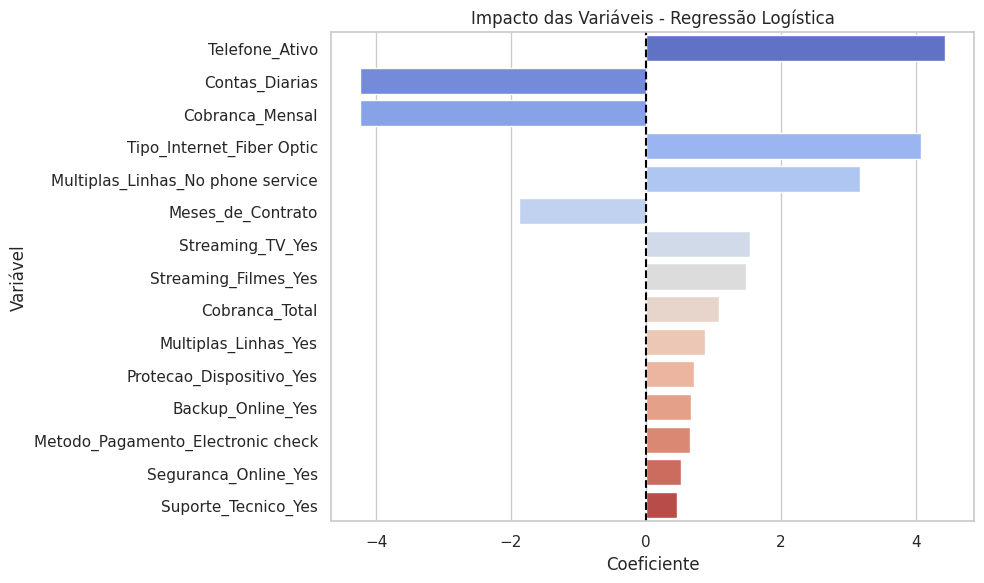

In [110]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Impacto das variáveis com Randon Forest
importancias = rf_model.feature_importances_
nomes = X_train.columns
df_import = pd.DataFrame({'Variável': nomes, 'Importância': importancias})
df_import = df_import.sort_values(by='Importância', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Variável', data=df_import, palette='viridis')
plt.title('Variáveis Mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

#Impacto das vari[aveis com Regressão
coef = pipeline_lr.named_steps['lr'].coef_[0]
nomes = X_train.columns
df_coef = pd.DataFrame({'Variável': nomes, 'Coeficiente': coef})
df_coef['Impacto'] = df_coef['Coeficiente'].abs()
df_coef = df_coef.sort_values(by='Impacto', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Variável', data=df_coef, palette='coolwarm')
plt.title('Impacto das Variáveis - Regressão Logística')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

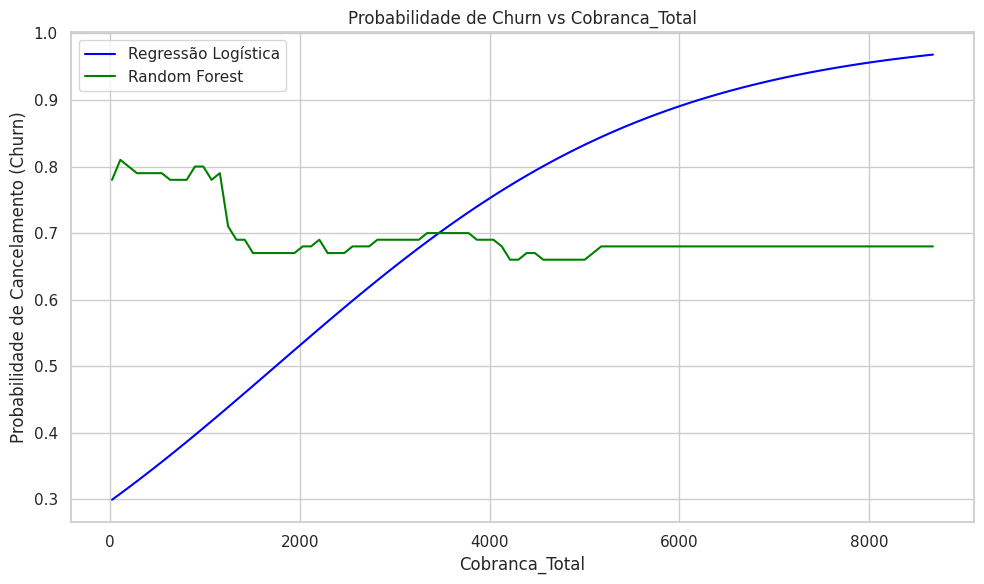

In [111]:
import numpy as np

variavel = 'Cobranca_Total' #'Cobranca_Total''Meses_de_Contrato'

# Gerar um intervalo de valores
valores = np.linspace(X_train[variavel].min(), X_train[variavel].max(), 100)

# Base de referência: média dos dados de treino
X_ref = pd.DataFrame(X_train.mean()).T

# Criar cópias alterando só a variável escolhida
X_plot = pd.concat([X_ref]*len(valores), ignore_index=True)
X_plot[variavel] = valores

# Aplicar scaler na regressão
scaler = pipeline_lr.named_steps['scaler']
X_plot_scaled = scaler.transform(X_plot)

# Obtendo as  probabilidades
probs_lr = pipeline_lr.named_steps['lr'].predict_proba(X_plot_scaled)[:, 1]
probs_rf = rf_model.predict_proba(X_plot)[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(valores, probs_lr, label='Regressão Logística', color='blue')
plt.plot(valores, probs_rf, label='Random Forest', color='green')
plt.xlabel(variavel)
plt.ylabel('Probabilidade de Cancelamento (Churn)')
plt.title(f'Probabilidade de Churn vs {variavel}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.1 Analise dos modelos preditivos.
Random Forest apresentou o melhor desempenho nas métricas e não apresentou  sinais aparentes de overfitting. Ofereceu medidas de importância relativa, mas não a direção do impacto.

Regressão Logística teve um bom desempenho, com bom equilíbrio entre precisão e recall. Como modelo mais simples, ofereceu um entendimento melhor dos fatores através dos coeficientes, sendo útil para entender se uma variável aumenta ou reduz a chance de churn.

O SMOTE contribuiu para o bom desempenho equilibrando a classe minoritária.
 Ambos modelos foram capazes de capturar bem os padrões dos dados.
Não fsendo identificado overfitting ou underfitting significativo em nenhum dos modelos.


# 4 Interpretação e conclusão.
Através da comparação entre os modelos de Regressão Logística e Random Forest, conseguimos identificar variáveis críticas que impactam a probabilidade de um cliente cancelar o serviço. A seguir, detalhamos os principais achados e suas implicações práticas.
Fatores que mais influenciam o Churn
1. Meses de Contrato
Random Forest e Regressão Logística indicam fortemente que clientes com menor tempo de contrato têm maior chance de churn.

Gráfico mostra que a probabilidade de cancelamento diminui drasticamente à medida que o cliente permanece mais tempo com a operadora.

Estratégia: Criar incentivos para fidelização nos primeiros meses (ex.: descontos progressivos ou bônus de renovação).

2. Cobrança Total e Cobrança Mensal
A Cobrança Total aparece como um dos fatores mais importantes no Random Forest.

A Cobrança Mensal tem coeficiente positivo na Regressão Logística, indicando que cobranças mais altas aumentam o churn.

Estratégia: Oferecer planos mais transparentes ou com controle de gastos para evitar surpresas na fatura.

3. Tipo de Internet
Clientes com fibra óptica tendem a ter maior probabilidade de churn, conforme observado no impacto positivo do coeficiente.

Pode estar relacionado à concorrência e ofertas semelhantes no mercado.

Estratégia: Aumentar diferenciais nos pacotes com fibra (ex.: suporte técnico rápido, bônus de velocidade).

4. Contas Diárias e Serviços Ativos
Clientes que fazem uso mais frequente (mais contas, mais serviços como TV, proteção, backup) demonstram comportamentos diferentes:

5. Método de Pagamento
Pagamentos via Electronic Check e Credit Card automático apareceram como variáveis relevantes.

----
Estrtégias para reduzir a taxa de Churn nos  primeiros meses:


1. Cirar programas de fidelidade nos primeiros 6 meses para reduzir o risco de churn inicial.

2. Alterar os pacotes caros com alta taxa de cancelamento.

3. Desenvolder ofertas customizadas com base no perfil de uso e método de pagamento.

4. Realizar o monitoramento contínuo de variáveis críticas.

